In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
from xgboost import XGBRegressor

df=pd.read_csv('Boston.csv')

X = df[['RM', 'AGE', 'CRIM', 'NOX']]
y= df['PRICE']
X['AGE']=np.where(X['AGE']>77.5,1,0)
X100 = X.iloc[100:200]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [71]:
model = XGBRegressor(n_estimators=500,max_depth=3) 
model.fit(X, y)
y_pred=model.predict(X)
np.corrcoef(y,y_pred)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


array([[1.       , 0.9995944],
       [0.9995944, 1.       ]])

In [72]:
import shap
explainer = shap.TreeExplainer(model)
shap_values=explainer.shap_values(X100)
interaction_values = explainer.shap_interaction_values(X100) 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [73]:
#Get shape of interaction values
expected=explainer.expected_value
print(expected)
print(shap_values[0])
print(np.shape(interaction_values))
print(shap_values[0,0]-sum(interaction_values[0,0,1:]))
# SHAP interaction values for first employee
pd.DataFrame(interaction_values[0],index=X.columns,columns=X.columns)

22.532928
[ 3.6485026  -0.90288544  2.2141197  -0.06899463]
(100, 4, 4)
3.4952874779701233


,RM,AGE,CRIM,NOX
RM,3.495287,0.167001,0.121472,-0.135258
AGE,0.167000,-1.252763,0.309353,-0.126476
CRIM,0.121470,0.309355,1.473741,0.309554
NOX,-0.135258,-0.126476,0.309554,-0.116814


In [74]:
#Get model predictions
y_pred = model.predict(X100)

#Sum of interaction values for first employee
sum_shap = np.sum(interaction_values[0])

#Values below should be the same
print("Model prediction: {}".format(y_pred[0]))
print("Mean prediction + interaction values: {}".format(expected+sum_shap))

Model prediction: 27.423660278320312
Mean prediction + interaction values: 27.42367172241211


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'RM'),
  Text(0, 1.5, 'AGE'),
  Text(0, 2.5, 'CRIM'),
  Text(0, 3.5, 'NOX')])

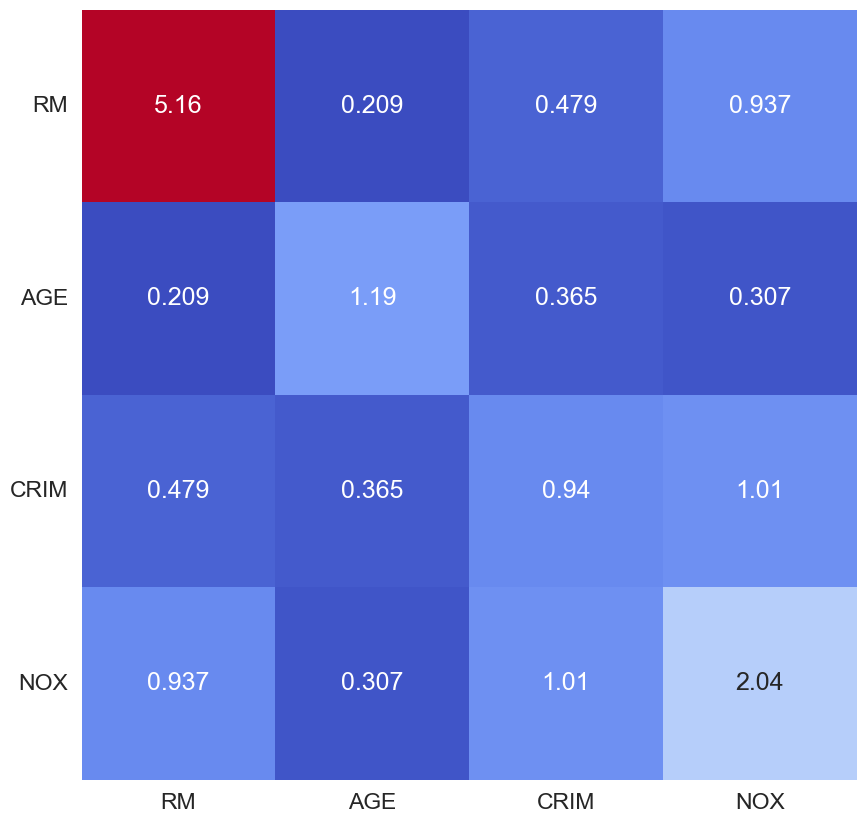

In [75]:
# Get absolute mean of matrices
mean_shap = np.abs(interaction_values).mean(0)
df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

# display 
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.3g',cbar=False)
plt.yticks(rotation=0) 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


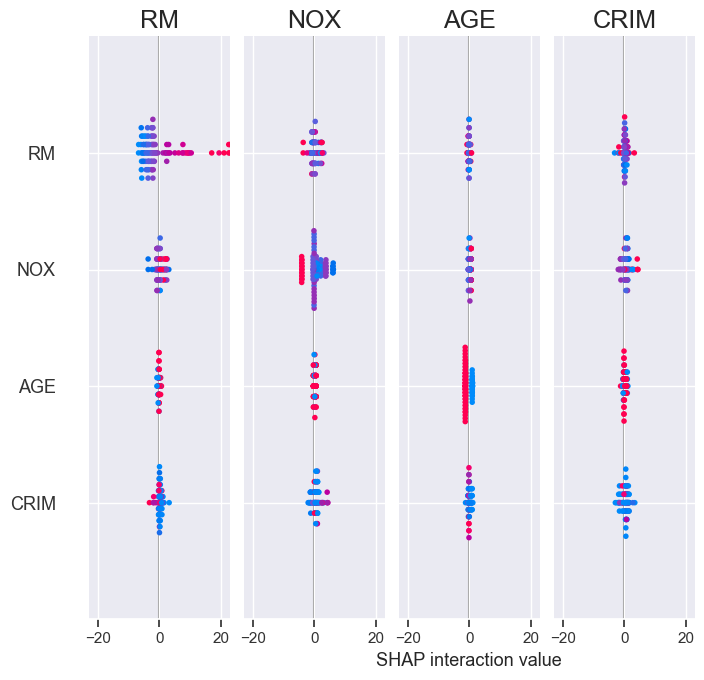

In [76]:
#Display summary plot For this plot, the interaction effects have already been doubled.
shap.summary_plot(interaction_values, X100)
#For example, we can see that the main effects of the degree, 
#experience, performance and sales are all positive.

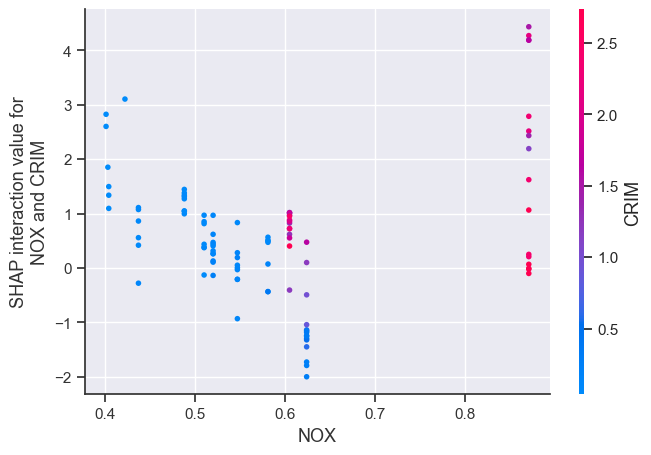

In [77]:
# Experience-degree depenence plot
shap.dependence_plot(("NOX", "CRIM"),interaction_values, X100, display_features=X)

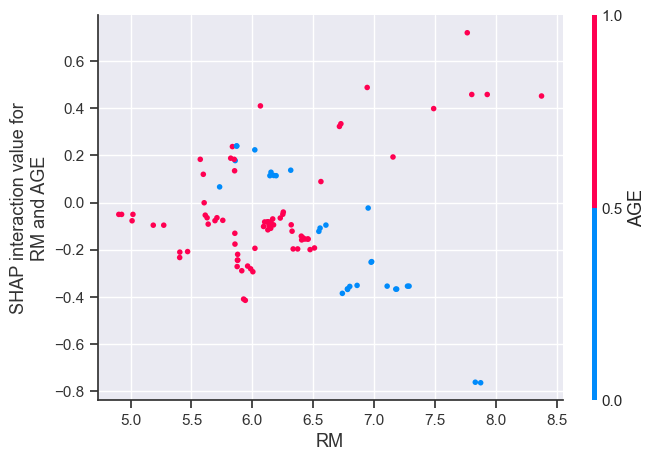

In [78]:
shap.dependence_plot(("RM", "AGE"),interaction_values, X100,display_features=X)